# PESTPP-GLM Part 1

In this notebook, we will run PESTPP-GLM to generate a jco matrix and stop - this is to support data worth testing

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template_history"
m_d = "master_glm"

/Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


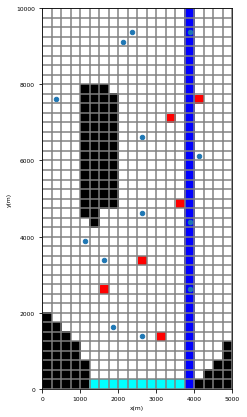

In [4]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

In [5]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
...,...,...,...,...,...,...,...
pp_vka0,pp_vka0,log,32,0,1,-1,0.5
pp_vka1,pp_vka1,log,32,0,1,-1,0.5
pp_vka2,pp_vka2,log,32,0,1,-1,0.5
welflux,welflux,log,25,0,1,-1,0.5


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K+ pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k+ by 10K+ matrix is also difficult.  So that means we need to fix a lot a parameters (this is not without implications!) #frownyface. Lets aim for ~500.

In [6]:
par = pst.parameter_data

In [7]:
# say goodbye to grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

633

In [8]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_prsity0', 'pp_prsity1',
       'pp_prsity2', 'pp_rech0', 'pp_ss0', 'pp_ss1', 'pp_ss2', 'pp_sy0',
       'pp_sy1', 'pp_sy2', 'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [9]:
#s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
#par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

633

In [10]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

cn_rech22     1
cn_rech6      1
cn_ss7        1
cn_vka6       1
cn_sy8        1
             ..
pp_rech0     32
pp_vka2      32
pp_hk0       32
pp_sy0       32
pp_sy2       32
Name: pargp, Length: 61, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [11]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"

pst.npar_adj

569

In [12]:
fi_const_grps = [g for g in pst.adj_par_groups if "cn" in g and "rech" not in g]
fi_const_grps.extend([g for g in pst.adj_par_groups if "welflux_k" in g])
par.loc[par.pargp.apply(lambda x: x in fi_const_grps),"partrans"] = "fixed"
fi_const_grps

['cn_hk6',
 'cn_hk7',
 'cn_hk8',
 'cn_prsity6',
 'cn_prsity7',
 'cn_prsity8',
 'cn_ss6',
 'cn_ss7',
 'cn_ss8',
 'cn_sy6',
 'cn_sy7',
 'cn_sy8',
 'cn_vka6',
 'cn_vka7',
 'cn_vka8',
 'welflux_k02']

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix for two purposes: 0. to conduct a formal data worth assessment; and 1. as the basis for (super) parameter upgrade iterations (we will reuse this jacobian), which we will then use to draw realizations from the FOSM posterior parameter covariance matrix and run those realizations to get the posterior forecast PDFs.

In [13]:
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:-1, npar_adj:548, nnz_obs:350


In [14]:
pyemu.os_utils.start_workers(t_d,"pestpp-glm","freyberg_pp.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)

That is all we need for FOSM, so stop here and relax! #dividends